In [1]:
import warnings
warnings.filterwarnings('ignore') #, category=UserWarning)

import numpy as np
from vorothreshold import voronoi_threshold_finder
from vorothreshold.read_funcs import read_voronoi_vide
import matplotlib.pyplot as plt

The standard methodology to postprocess vide voids in lightcone in order to find the corresponding threshold voids, requires a few quantities, which are:

- A list/array or a single value of threshold. This should be passed as the value of the normalized density, i.e. 1+$\delta$

- The array of the density corresponding to each tracer

- The path of vide directory, the one containing all the outputs 

- A range in which consider voids to be analyzed. This can be passed either as a comoving distance, or redshift range.

- Cosmological parameters to convert redshift in distance. If the cosmological model is $\Lambda$CDM, then $\Omega_{\rm m}$ is enough (other parameters are $w_0$ and $w_{\rm a}$)

The path to VIDE output and $\Omega_{\rm m}$ are:

In [2]:
vide_path='data/lightcone/examples/example_observation/sample_example_observation/'
OmegaM = 0.3

In the following code cell, we measure the mean number density at the position of each galaxy. To do so we measure the number density of galaxies as a function of redshift, and then assign the corresponding mean density to each galaxy redshift. 

WARNING: in the presence of angular mask, the mean density should by weighted also by it.

In this example we use the galaxy catalog stored in the VIDE output, that load it with the function `read_voronoi_vide` from the `read_funcs` submodule. The inputs of this function wants are the path of VIDE output directory and the sample name of the VIDE run. The output is the IDs of tracers (`ids_voro`) (which is the same of Voronoi cells), the corresponding Voronoi volumes (`VoroVol`), cartesian coordinate as computed by VIDE (`VoroXYZ`, note that these are not garateed to be the physical coordinates), finally the physical coordinates in R.A., Dec, and redshift (`RA`, `Dec`, `redshift`).

In [3]:
sample_name = 'example_observation'
ids_voro, VoroVol, VoroXYZ, RA, Dec, redshift = read_voronoi_vide(vide_path,sample_name)

To compute the number density as a function of the redshift we need the solid angle of the survey. We compute it by loading the `healpy` mask used by VIDE.

WANING: in that specific case the galaxy number density is approximately constant with respect the redshift, in general it should be fitted on interpolated.

The comoving range `comov_range` computed here, will be used in a further step. Its purpose is to avoid have voids touching the borders (voids that have Voronoi cells crossing this boundary after the threshold procedure, will not be considered).

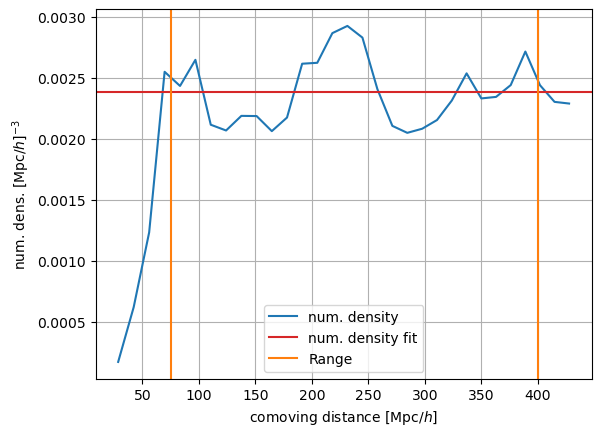

In [4]:
from vorothreshold.utilities import ComovingDistanceOverh
import healpy as hp

mask_gal_file = vide_path + 'mask_map.fits'
mask = hp.read_map(mask_gal_file)
sky_frac = np.sum(mask)/mask.shape[0]

w0=-1.
wa=0.
dist_z = ComovingDistanceOverh(OmegaM,w0,wa)
hist_z, z_bins = np.histogram(redshift,bins=31)

comov_bins = dist_z.get_dist(z_bins)
comov3 = dist_z.get_dist(z_bins)**3
shell_vol = 4*np.pi/3.*sky_frac*(comov3[1:] - comov3[:-1])
z_mean = 0.5 * (z_bins[1:] + z_bins[:-1])
dist_mean = dist_z.get_dist(z_mean)
comov_range = (75,400)
mean_dens = np.mean((hist_z/shell_vol)[(dist_mean>=comov_range[0]) & (dist_mean<=comov_range[1])])
plt.plot(dist_mean,hist_z/shell_vol,label='num. density')
plt.axhline(mean_dens,label='num. density fit',c=plt.cm.tab10(3))
plt.axvline(comov_range[0],label='Range',c=plt.cm.tab10(1))
plt.axvline(comov_range[1],c=plt.cm.tab10(1))
plt.legend()
plt.ylabel('num. dens. [Mpc/$h$]$^{-3}$')
plt.xlabel('comoving distance [Mpc/$h$]')
plt.grid()

zDens = np.full(redshift.shape[0],mean_dens)

The computation are performed in the initialization of the `voronoi_threshold_finder` class, passing as arguments the ones listed above. The `thresholds` list can contain many values.

In [5]:

thresholds = [0.2,0.3]

th_voids = voronoi_threshold_finder(thresholds,lightcone=True,tracer_dens=zDens,vide_path=vide_path,comov_range=comov_range,OmegaM=OmegaM,w0=w0,wa=wa,verbose=True)


    Loading VIDE data.
        done: 0 h 0 min 0.5739786624908447 sec.
max_num_part < 0: authomatically set to 5 * max(num_part): 3685
    voronoi_threshold started, nthreads = 32

    voronoi_threshold started

    nthreads set to 32

    max_num_part set to 3685

    computation started
    done, 0 h 0 min 10.804256200790405 sec. 

        main computation done: 0 h 0 min 10.894858837127686 sec.
    angular and radial mask started.
        done: 0 h 0 min 1.7940080165863037 sec.


In [6]:
max_voro_in_voids = np.max(th_voids.get_values(np.max(thresholds),'Ncells',1.))
max_voro_in_voids = int(max_voro_in_voids) + int(max_voro_in_voids%1 > 0)
print('max_num_part passed:',th_voids.max_num_part,'max num of voronoi in one void:',max_voro_in_voids)

max_num_part passed: 3685 max num of voronoi in one void: 14


To get threshold void properties, we use the `get_values` function from the `voronoi_threshold_finder` class. The arguments are the specific threshold value, among the values in `thresholds`, the quantity we want to obtain, and the overlapping fraction,`frac_ovlp`. This last quantity represents the maximum fractional amount of volume shared with an anther void. It is a free parameter, any value below or equal to 0.5 is fine. The corresponding output will contains voids which overlaps for a fraction of their volume minor or equal to `frac_ovlp`. The use of `frac_ovlp` is necessary to avoid double counting, as the thresholding procedure may merge adjacent basins in a unique void.

The ids of non-overlapping voids for a specific `frac_ovlp` is computed the first time that the value is passed to the `get_values` function. Alternatively, the ids can be computed by calling the `compute_overlaps` function, which accept as arguments both a single `frac_ovlp`, or multiple values passed as a list or a `numpy` array. In such a case, all the computations for all the combination `frac_ovlp` and `thresholds` values will be performed in parallel.

In [9]:
th_voids.compute_overlaps(np.array([0.5,0.25,0.]))

print('keys:',th_voids.id_out.keys())
print('keys:',th_voids.id_out[0].keys())


0

overlapping_fraction started.

    nthreads set to 32

    R_max computed. Max val = 32.47024789610827

    Lbox not passed, using xyz_vds as reference:
    min(xyz_vds) = -293.71617464148557 -339.1269207294771 13.308437338187048
    max(xyz_vds) = 184.31783990462554 -125.24078599779799 239.8317024475696
    Lbox = 478.0340145461111

    ngrid not passed. Set to optimal value: 15

    order_ids_tracers_selected_in_voxels started
    done, 0 h 0 min 0.0006854534149169922 sec.

    computation started (periodic-boundaries condition off)
    done, 0 h 0 min 0.0004189014434814453 sec. 

1

overlapping_fraction started.

    nthreads set to 32

    R_max computed. Max val = 30.904216006008173

    Lbox not passed, using xyz_vds as reference:
    min(xyz_vds) = -292.16780142387853 -344.1278907340821 13.514809527566394
    max(xyz_vds) = 239.81006320041777 -105.3468335812573 343.25203666602334
    Lbox = 531.9778646242963

    ngrid not passed. Set to optimal value: 17

    order_ids_trace

The following cell extract some threshold voids properties with `get_values`. The list of available options is the following: 


- Ncells: Number of Voronoi cells contained in each void. This is an array of float as the last Voronoi cell adds as the volume fraction considered to reach the threshold value. dtype=float64, shape=(N,)
        
- ID_original_sample: IDs of the void of the original VIDE catalog used to start the thresholding process. dtype=int64, shape=(N,)
            
- id_selected: IDs of voids of the entire voronoi_threshold output that reach the threshold value and satisfying the overlaps condition. dtype=int64, shape=(N,)

- id_wrt_all: IDs of voids of the entire voronoi_threshold output that reach the threshold value and satisfying the overlaps condition. dtype=int64, shape=(N,)

- xyz: Comoving coordinates of the volume weighted barycenter. dtype=float64, shape=(N,3)

- RA: Right ascension of the volume weighted barycenter. dtype=float64, shape=(N,)

- DEC: Declination of the volume weighted barycenter. dtype=float64, shape=(N,)

- comov_dist: Comoving distance of the volume weighted barycenter. dtype=float64, shape=(N,)

- redshift: Redshift of the volume weighted barycenter. dtype=float64, shape=(N,)

- volume: Void volumes. dtype=float64, shape=(N,)

- radius: Void effective radius. dtype=float64, shape=(N,)

- ell_eigenvalues: eigenvalues of the inertial tensor. dtype=float64, shape=(N,3)

- ell_eigenvectors: eigenvectors of the inertial tensor. dtype=float64, shape=(N,3,3)


In [ ]:
xyz = dict()
radius = dict()
z_voids = dict()
frac_ovlp = 0.5
for thr in thresholds:
    xyz[thr] = dict()
    radius[thr] = dict()
    z_voids[thr] = dict()
    xyz[thr][frac_ovlp] = th_voids.get_values(thr,'xyz',frac_ovlp)
    radius[thr][frac_ovlp] = th_voids.get_values(thr,'radius',frac_ovlp)
    z_voids[thr][frac_ovlp] = th_voids.get_values(thr,'redshift',frac_ovlp)
    #print(xyz[thr][frac_ovlp].shape,radius[thr][frac_ovlp].shape,z_voids[thr][frac_ovlp].shape)

In [ ]:
from vorothreshold.utilities import from_XYZ_to_rRAdec
from vorothreshold.read_funcs import vide_voids_cat
thr = 0.3
ith = 0
comov_dist = dict()
RA = dict()
DEC = dict()
volume = dict()
for frac_ovlp in [1.,0.5,0.25,0.1,0.]:
    comov_dist[thr] = dict()
    RA[thr] = dict()
    DEC[thr] = dict()
    volume[thr] = dict()
    
    xyz[thr][frac_ovlp] = th_voids.get_values(thr,'xyz',frac_ovlp)
    radius[thr][frac_ovlp] = th_voids.get_values(thr,'radius',frac_ovlp)
    volume[thr][frac_ovlp] = th_voids.get_values(thr,'volume',frac_ovlp)
    RA[thr][frac_ovlp] = th_voids.get_values(thr,'RA',frac_ovlp)
    DEC[thr][frac_ovlp] = th_voids.get_values(thr,'DEC',frac_ovlp)
    z_voids[thr][frac_ovlp] = th_voids.get_values(thr,'redshift',frac_ovlp)
    comov_dist[thr][frac_ovlp] = np.sum(xyz[thr][frac_ovlp]**2,axis=1)**0.5 #th_voids.get_values(thr,'comov_dist',frac_ovlp)
    print(frac_ovlp,xyz[thr][frac_ovlp].shape,radius[thr][frac_ovlp].shape,z_voids[thr][frac_ovlp].shape)
dist_all, RA_all, DEC_all = from_XYZ_to_rRAdec(th_voids.Xcm[:,ith,0],th_voids.Xcm[:,ith,1],th_voids.Xcm[:,ith,2])

barycenter,Reff_vide,redshift_vds,voidID,RAvide,DEC_vide,coreID,core_dens,core_pos,RAcore,DECcore,redshift_core = vide_voids_cat(vide_path,'example_observation',
    values_out=['barycenter','radius','redshift','voidID','RA','DEC','core_ID','core_dens','core_pos','RAcore','DECcore','redshift_core'],as_dict=False)
fig = plt.figure()
#plt.scatter(dist_z.get_dist(redshift_vds),Reff_vide)
plt.scatter(dist_all,(th_voids.Vol_interp[:,ith]* 3. / (4. * np.pi)) ** (1./3.),label='overapping or touching bourders',s=10)
plt.scatter(comov_dist[thr][frac_ovlp],radius[thr][frac_ovlp],label='final void catalog')#,s=5)
#plt.axvline(comov_range[0])
#plt.axvline(comov_range[1])
#plt.xlim(250,450)
#print(np.argmax(th_voids.Vol_interp[:,0]),np.max(th_voids.Vol_interp[:,0]))
plt.legend()
plt.grid()
plt.xlabel('Comov. dist Mpc/$h$')
plt.ylabel('$R_{\\rm eff}$ Mpc/$h$')

fig = plt.figure()
plt.scatter(RA_all,DEC_all,label='overapping or touching bourders',s=10)
plt.scatter(RA[thr][frac_ovlp]%360,DEC[thr][frac_ovlp],label='final void catalog')#,s=5)
plt.legend()
plt.grid()
plt.xlabel('R.A.')
plt.ylabel('DEC')


print(th_voids.Vol_interp.shape,Reff_vide.shape)


fig = plt.figure(figsize=(12,12))
ax = dict()
for i in range(3):
    ax[i] = plt.subplot2grid((2,2), (int(i/2),i%2), rowspan=1, colspan=1)
    ax[i].scatter(th_voids.Xcm[:,ith,i%3],th_voids.Xcm[:,ith,(i+1)%3],s=(th_voids.Vol_interp[:,ith]* 3. / (4. * np.pi)/3) ** (2./3.),alpha=0.5,label='overapping or touching bourders')
    ax[i].scatter(xyz[thr][frac_ovlp][:,i%3],xyz[thr][frac_ovlp][:,(i+1)%3],s=(volume[thr][frac_ovlp]* 3. / (4. * np.pi)/3) ** (2./3.),label='final void catalog')
    ax[i].axis('equal')
    ax[i].grid()
    ax[i].set_xlabel(['x','y','z'][i%3]+' [Mpc/$h$]')
    ax[i].set_ylabel(['x','y','z'][(i+1)%3]+' [Mpc/$h]$')
ax[0].legend()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(th_voids.Xcm[:,ith,0],th_voids.Xcm[:,ith,1],th_voids.Xcm[:,ith,2],s=(th_voids.Vol_interp[:,ith]* 3. / (4. * np.pi)/3) ** (2./3.),alpha=0.2)
ax.scatter(xyz[thr][frac_ovlp][:,0],xyz[thr][frac_ovlp][:,1],xyz[thr][frac_ovlp][:,2])
ax.axis('equal')
ax.set_xlabel('x [Mpc/$h$]')
ax.set_ylabel('y [Mpc/$h$]')
ax.set_zlabel('z [Mpc/$h$]')

In [ ]:
#from vorothreshold.read_funcs import read_voronoi_vide
#asd = voro_in_vide_voids('data/lightcone/examples/example_observation/sample_example_observation/','example_observation')

id_selected = np.arange(th_voids.Xcm.shape[0])[th_voids.Ncells_in_void[:,0] > 10]
id_ovlp_out = th_voids.get_values(thr,'id_selected',frac_ovlp)
fig = plt.figure(figsize=(15,15))
ax = dict()
for i in range(3):
    ax[i] = plt.subplot2grid((2,2), (int(i/2),i%2), rowspan=1, colspan=1)
    ax[i].scatter(VoroXYZ[:,i%3],VoroXYZ[:,(i+1)%3],s=0.1,alpha=0.02,c='k')
progr = 0
for id in id_selected:
    Xcm_interp = th_voids.Xcm[id,0,:]
    IDthresholds = th_voids.ID_voro_dict[id][:int(th_voids.Ncells_in_void[id,0]+1)]
    alpha = 0.1
    for i in range(3):
        ax[i].scatter(VoroXYZ[IDthresholds,i%3],VoroXYZ[IDthresholds,(i+1)%3],s=9,alpha=0.1)
            #ax[i].scatter(Xcm_interp[i%3],Xcm_interp[(i+1)%3])
        #ax[i].scatter(core_pos[iv,i%3],core_pos[iv,(i+1)%3],c='r',)
        #ax[i].scatter(barycenter[iv,i%3],barycenter[iv,(i+1)%3],c='m')
    progr +=1
progr = 0
for id in id_ovlp_out:
    Xcm_interp = th_voids.Xcm[id,0,:]
    IDthresholds = th_voids.ID_voro_dict[id][:int(th_voids.Ncells_in_void[id,0]+1)]
    
    for i in range(3):
        ax[i].scatter(VoroXYZ[IDthresholds,i%3],VoroXYZ[IDthresholds,(i+1)%3],s=9,alpha=1.)
            #ax[i].scatter(Xcm_interp[i%3],Xcm_interp[(i+1)%3])
        #ax[i].scatter(core_pos[iv,i%3],core_pos[iv,(i+1)%3],c='r',)
        #ax[i].scatter(barycenter[iv,i%3],barycenter[iv,(i+1)%3],c='m')
    progr +=1
for i in range(3):
    ax[i].axis('equal')
    ax[i].set_xlabel(['x','y','z'][i%3]+' [Mpc/$h$]')
    ax[i].set_ylabel(['x','y','z'][(i+1)%3]+' [Mpc/$h$]')
    ax[i].grid()
ax[2].scatter(np.nan,np.nan,s=9,alpha=1.,label='Voronoi cells of selected voids')
ax[2].scatter(np.nan,np.nan,s=9,alpha=0.1,label='Voronoi cells of overlapping or touching borders voids')
ax[2].scatter(np.nan,np.nan,s=0.1,alpha=0.02,c='k',label='Galaxies')
ax[2].legend()